In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.model_selection import GridSearchCV

import xgboost as xgb

## Input data

In [2]:
dfFull = pd.read_csv('../Dataset/full_feature.csv')
dfFull.dropna(inplace=True)
dfFull.head(2)

,originalRate,size,starRating,AIR_CONDITIONING,BALCONY_TERRACE,BATHROBES,BATHTUB,BLACKOUT_DRAPES_CURTAINS,COFFEE_TEA_MAKER,COMPLIMENTARY_BOTTLED_WATER,...,PARK,HOSPITAL,MUSEUM,GALLERY,PLACE_OF_WORSHIP,TRAIN_STATION,ZOO,ENTERTAINMENT,GARDEN.1,THEATER
0,1227273,46.0,4.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,596694,31.0,4.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [3]:
X = dfFull.drop('originalRate', axis=1)
y = dfFull['originalRate']

In [4]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(3895, 293) (974, 293) (3895,) (974,)


In [5]:
# Train the model with XGBoost
xg_reg = xgb.XGBRegressor(
    objective ='reg:squarederror',
    eval_metric='rmse'
)
xg_reg.fit(X_train, y_train)

XGBRegressor(eval_metric='rmse', objective='reg:squarederror')

In [6]:
print('Train evaluation')
preds = xg_reg.predict(X_train)
mse = mean_squared_error(y_train, preds)
rmse = np.sqrt(mse)
print('RMSE: ', '{0:,.0f}'.format(rmse))
print('R2: ', round(r2_score(y_train, preds),3))
print('-'*20)

print('Test evaluation')
preds = xg_reg.predict(X_test)
mse = mean_squared_error(y_test, preds)
rmse = np.sqrt(mse)
print('RMSE: ', '{0:,.0f}'.format(rmse))
print('R2: ', round(r2_score(y_test, preds),3))

Train evaluation
RMSE:  1,613,593
R2:  0.816
--------------------
Test evaluation
RMSE:  2,284,408
R2:  0.603


In [7]:
# Hyperparameter tuning
parameters = {
    'colsample_bytree':[0.5], #0.5
    'learning_rate':[ 0.05], #0.05
    'max_depth': [100], # 100
    'min_child_weight': [8], # 8
    'n_estimators': [350], # 350
    'subsample': [0.5], # 0.5
    'reg_alpha': [0], # 0
    'reg_lambda':[10],
}
# Set up score
scoring = ['neg_root_mean_squared_error', 'r2']

In [8]:
grid = GridSearchCV(
    xg_reg,
    parameters,
    scoring=scoring,
    cv=5,
    refit='neg_root_mean_squared_error',
    n_jobs=-1,
    verbose=3
    )
result = grid.fit(X_train, y_train)

Fitting 5 folds for each of 1 candidates, totalling 5 fits


In [9]:
grid.best_estimator_

XGBRegressor(colsample_bytree=0.5, eval_metric='rmse', learning_rate=0.05,
             max_depth=100, min_child_weight=8, n_estimators=350,
             objective='reg:squarederror', reg_lambda=10, subsample=0.5)

In [10]:
grid.best_params_

{'colsample_bytree': 0.5,
 'learning_rate': 0.05,
 'max_depth': 100,
 'min_child_weight': 8,
 'n_estimators': 350,
 'reg_alpha': 0,
 'reg_lambda': 10,
 'subsample': 0.5}

In [11]:
print('Train evaluation')
preds = grid.predict(X_train)
mse = mean_squared_error(y_train, preds)
rmse = np.sqrt(mse)
# print('MAE: ', '{0:,.0f}'.format(mean_absolute_error(y_train, preds)))
# print('MSE: ', '{0:,.0f}'.format(mse))
print('RMSE: ', '{0:,.0f}'.format(rmse))
print('R2: ', round(r2_score(y_train, preds),3))
print('-'*20)

print('Test evaluation')
preds = grid.predict(X_test)
mse = mean_squared_error(y_test, preds)
rmse = np.sqrt(mse)
# print('MAE: ', '{0:,.0f}'.format(mean_absolute_error(y_test, preds)))
# print('MSE: ', '{0:,.0f}'.format(mse))
print('RMSE: ', '{0:,.0f}'.format(rmse))
print('R2: ', round(r2_score(y_test, preds),3))

Train evaluation
RMSE:  1,116,663
R2:  0.912
--------------------
Test evaluation
RMSE:  1,883,816
R2:  0.73


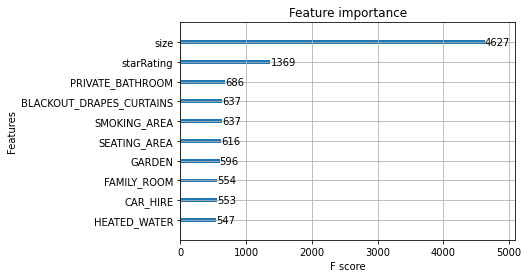

In [12]:
xgb.plot_importance(grid.best_estimator_, max_num_features=10)
plt.savefig('feature_importance.png', dpi=300)

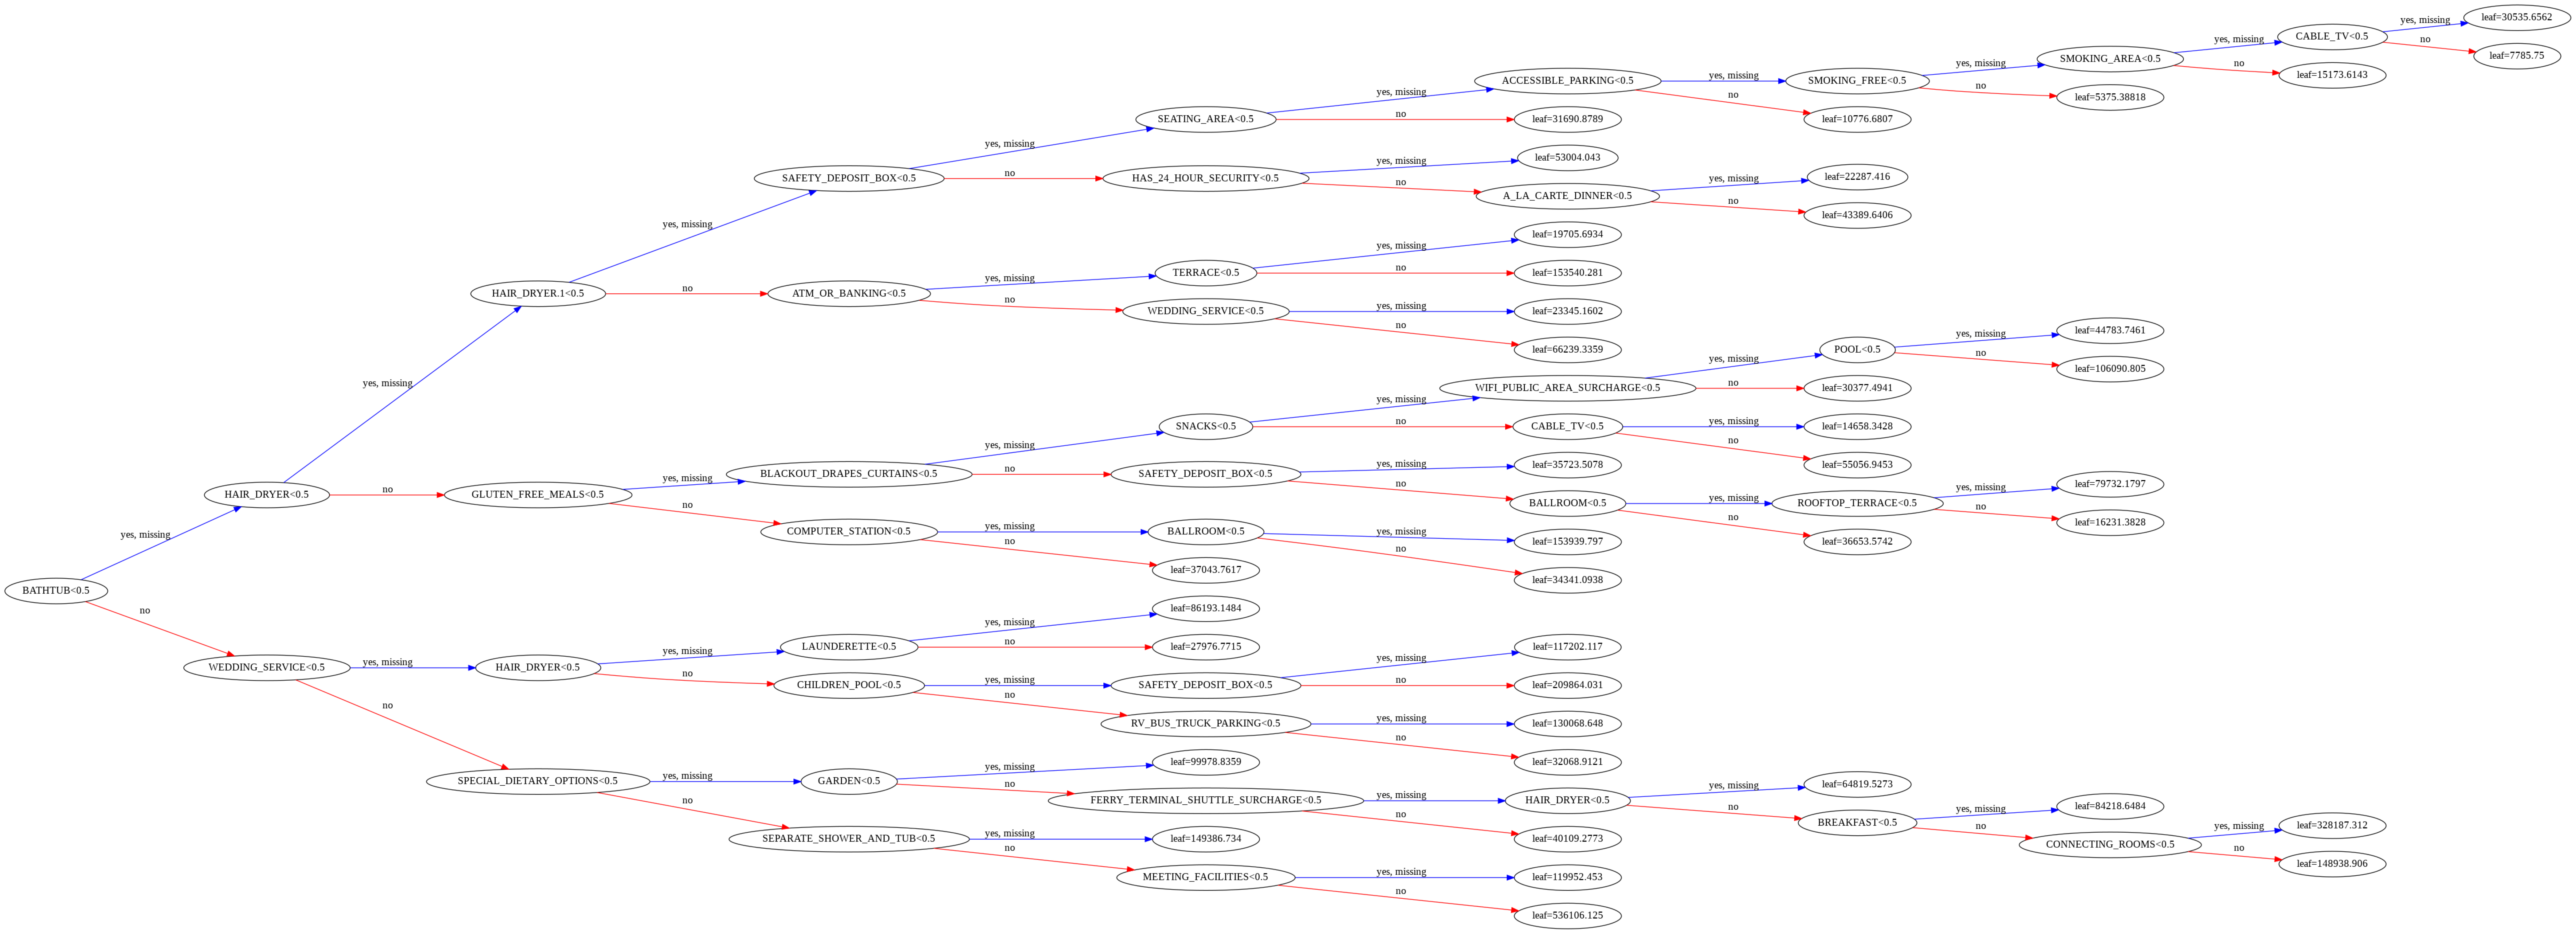

In [13]:
from xgboost import plot_tree

plot_tree(grid.best_estimator_, num_trees=0, rankdir='LR')
fig = plt.gcf()
fig.set_size_inches(150, 100)
plt.savefig('tree.png')